# Competition Task 1: Modulation classification

Wellcome to this years 2025 MLOC competition!
If you have any questions, don't hesitate to ask a question in the forum or send an email to sisi.miao@kit.edu or rodrigo.fischer@kit.edu.

Have fun!

Enter your team name here:

In [1]:
# Before you start, please enter your team name!
team_name = 'ZSC'

The main code starts here...

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [3]:
# In case you want to use PyTorch to build your clasifier
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


In [4]:
# Checks if the data you upload has the correct type/form
def check_predictions(test_data, predictions, valid_values):
    """Checks if predictions has the right length and type."""
    if isinstance(predictions,np.ndarray):
        print('type ok.')
    else:
        raise Exception('wrong type, predictions should be of type np.ndarray')

    if predictions.ndim != 1:
        raise Exception('wrong dimension, predictions must have dim 1')
    else:
        print('dim ok.')

    if len(test_data) != len(predictions):
        raise Exception('wrong length, "X_test" and "predictions" must have the same length.')
    else:
        print('length ok.')

    all_values_valid = True
    for i in range(len(predictions)):
        if (predictions[i] not in valid_values):
            print('All values of "predictions" have to be in "valid data".')
            all_values_valid = False
            break
    if all_values_valid:
        print('Predictions are valid values.')


In [5]:
# Helper function to compute the classification error rate 
def CER(predictions, labels):
    """Calculates the classification error rate."""
    return (np.sum(predictions != labels) / len(predictions))

## Task 1: Find the modulation format
You receive the samples of a communications signal and your task is to devise an ML solution to determine the unknown modulation format used. At your disposal you have a dataset with $3.2\cdot 10^5$ example sequences of 128 complex samples each (Inphase and Quadrature components), accompanied by an array containing the true modulation format used to generate each sequence and an array containing the sequence SNR. 

To perform cross-validation of your strategy, we also make available a statistically identical and smaller dataset with the corresponding modulation format and SNR labels. Your model will be evaluated on a test dataset, that will also be made available, but whose labels won't be revealed. Use the SNR information however you like. **Note that the test dataset does _not_ contain the SNR values. You can only use the SNR values for training and validation if you like.**  The predicted values must be given as integer values, each integer indicating a certain modulation format.

As a side result, show a plot containing the classification error on the evaluation dataset for each SNR separatelly. Optionally, plot also the confusion matrices.

Aditionally, feel free to try also classical DSP approaches.

The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `Y_train` and the corresponding SNR is given in `SNR_train`. The label in `Y_train` corresponds to one of the modulation formats in `modulation_formats`.

In [6]:
# Check if data sets are available
from os.path import exists
file_prefix='./'
if exists('/home/jovyan/work/__shared/MLOC_Competition_2025_task1_dataset_train.pkl'):
    file_prefix ='/home/jovyan/work/__shared/'

if not exists('/home/jovyan/work/__shared/MLOC_Competition_2025_task1_dataset_train.pkl') and not exists('MLOC_Competition_2025_task1_dataset_train.pkl'):
    print('Training data must be either in __shared folder or in current folder')
        
if not exists('/home/jovyan/work/__shared/MLOC_Competition_2025_task1_dataset_valid.pkl') and not exists('MLOC_Competition_2025_task1_dataset_valid.pkl'):
    print('Training data must be either in __shared folder or in current folder')

if not exists('/home/jovyan/work/__shared/MLOC_Competition_2025_task1_test_data.pkl') and not exists('MLOC_Competition_2025_task1_test_data.pkl'):
    print('Training data must be either in __shared folder or in current folder')


In [7]:
# Load training dataset
with open(file_prefix+'MLOC_Competition_2025_task1_dataset_train.pkl', "rb") as f:
    X_train_task_1 = pickle.load(f)
    Y_train_task_1 = pickle.load(f)
    SNR_train_task_1 = pickle.load(f)
    mod_names_task_1 = pickle.load(f)
    SNRs_task_1 = pickle.load(f)
    
# Load validation dataset
with open(file_prefix+'MLOC_Competition_2025_task1_dataset_valid.pkl', "rb") as f:
    X_valid_task_1 = pickle.load(f)
    Y_valid_task_1 = pickle.load(f)
    SNR_valid_task_1 = pickle.load(f)
    
# Load test data
with open(file_prefix+'MLOC_Competition_2025_task1_test_data.pkl', "rb") as f:
    X_test_task_1 = pickle.load(f)

In [8]:
print('SNR values: ', SNRs_task_1)
print('Modulation names', mod_names_task_1)

SNR values:  [ 0  2  4  6  8 10 12 14 16 18]
Modulation names ['BPSK', 'QPSK', '8-PSK', '16-QAM']


Here you can visualize the sequences:

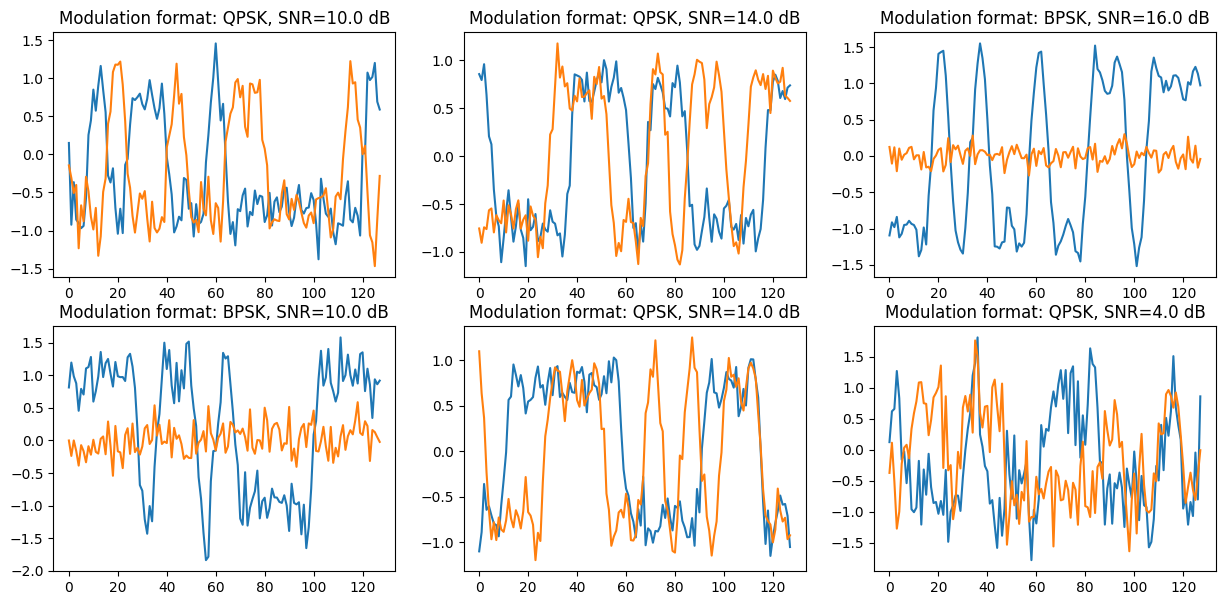

In [18]:
starti = np.random.randint(0,X_train_task_1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task_1[k+starti,:]))
    plt.plot(np.imag(X_train_task_1[k+starti,:]))
    plt.title(f'Modulation format: {mod_names_task_1[Y_train_task_1[k+starti]]}, SNR={SNR_train_task_1[k+starti]} dB')

    

In [10]:
# Data preprocessing
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

# Label Modulation digitization
if isinstance(Y_train_task_1[0], str):
    Y_train_int = np.array([mods.index(x) for x in Y_train_task_1])
else:
    Y_train_int = np.array(Y_train_task_1)

if isinstance(Y_valid_task_1[0], str):
    mods = sorted(list(set(Y_valid_task_1)))
    Y_valid_int = np.array([mods.index(x) for x in Y_valid_task_1])
else:
    mods = sorted(list(set(Y_valid_task_1)))
    Y_valid_int = np.array([mods.index(x) for x in Y_valid_task_1])


# Split into training and test sets
X_train = np.array(X_train_task_1)   
Y_train = Y_train_int                

X_test  = np.array(X_valid_task_1)   
Y_test  = Y_valid_int 

# One-hot code 
def to_onehot(vec):
    vec_hot = np.zeros([len(vec), max(vec) + 1])
    vec_hot[np.arange(len(vec)), vec] = 1
    return vec_hot

Y_train_oh = to_onehot(Y_train)
Y_test_oh = to_onehot(Y_test)

# reshape
X_train = np.reshape(X_train, (-1, 1, 2, 128))
X_test = np.reshape(X_test, (-1, 1, 2, 128))

#  X_train: shape (N, 1, 2, 128), dtype float32 or float64
#  Y_train_oh: shape (N, num_classes), one-hot ，dtype float32



Epoch 010 — train loss: 0.1896, val loss: 0.1832
Epoch 020 — train loss: 0.1764, val loss: 0.1810
Epoch 030 — train loss: 0.1602, val loss: 0.3019
Epoch 040 — train loss: 0.1487, val loss: 0.2244
Epoch 050 — train loss: 0.1359, val loss: 0.2053
Epoch 060 — train loss: 0.1256, val loss: 0.1967
Epoch 070 — train loss: 0.1131, val loss: 0.1790
Epoch 080 — train loss: 0.0986, val loss: 0.1741
Epoch 090 — train loss: 0.0918, val loss: 0.1825
Epoch 100 — train loss: 0.0878, val loss: 0.1926
Epoch 110 — train loss: 0.0804, val loss: 0.1646
Epoch 120 — train loss: 0.0747, val loss: 0.2077
Epoch 130 — train loss: 0.0795, val loss: 0.1961
Epoch 140 — train loss: 0.0656, val loss: 0.1929
Epoch 150 — train loss: 0.0654, val loss: 0.1859


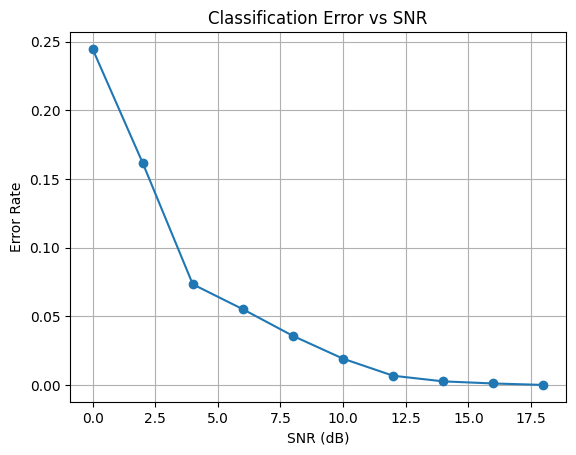

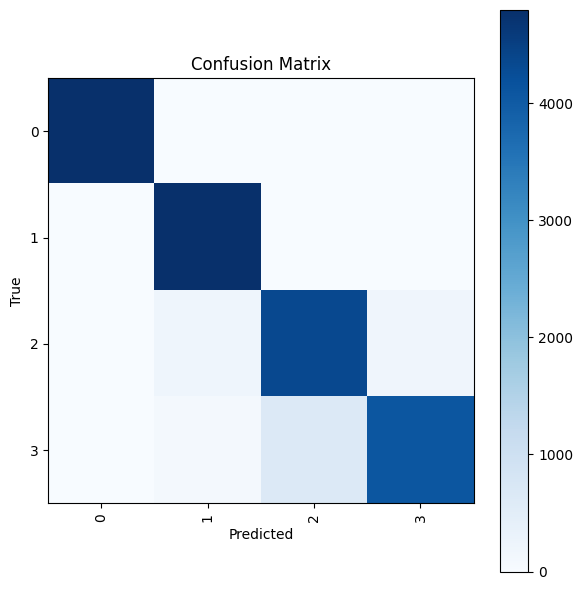

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# ─── 1) PREPARE EXISTING DATA ────────────────────────────────────────────────

# a) integer-encode your labels
if isinstance(Y_valid_task_1[0], str):
    mods = sorted(set(Y_valid_task_1))
else:
    mods = sorted(set(Y_valid_task_1))
Y_int = np.array([mods.index(y) for y in Y_valid_task_1])

# b) build IQ tensor shape (N,1,2,128)
X = np.array(X_valid_task_1)            # (N,128) complex
X = np.stack([X.real, X.imag], axis=1)  # (N,2,128)
X = X[:, None, :, :]                    # (N,1,2,128)
Y = Y_int                               # (N,)
SNR = np.array(SNR_valid_task_1)        # (N,)

# c) train/test split, keep SNR aligned
X_train, X_test, Y_train, Y_test, SNR_train, SNR_test = train_test_split(
    X, Y, SNR, test_size=0.3, random_state=1567, stratify=Y
)

# d) convert to CPU tensors (do NOT move to GPU yet)
X_train_t = torch.from_numpy(X_train).float()
Y_train_t = torch.from_numpy(Y_train).long()
X_test_t  = torch.from_numpy(X_test).float()
Y_test_t  = torch.from_numpy(Y_test).long()

# e) DataLoaders with small batch size & pin_memory
batch_size = 32
train_loader = DataLoader(
    TensorDataset(X_train_t, Y_train_t),
    batch_size=batch_size, shuffle=True,  pin_memory=True
)
test_loader  = DataLoader(
    TensorDataset(X_test_t, Y_test_t),
    batch_size=batch_size, shuffle=False, pin_memory=True
)


# ─── 2) DEFINE THE CNN–LSTM ───────────────────────────────────────────────────────
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes, dr=0.5, lstm_hidden=50, fc_hidden=256):
        super().__init__()
        # three Conv2d layers, padding preserves width=128
        self.conv1 = nn.Conv2d(1, 50, (1,7), padding=(0,3))
        self.conv2 = nn.Conv2d(50,50,(1,7), padding=(0,3))
        self.conv3 = nn.Conv2d(50,50,(1,7), padding=(0,3))
        self.dropout = nn.Dropout(dr)

        # after concat channels=100, width=128 → LSTM input_size=100*128
        self.lstm = nn.LSTM(input_size=100*128, hidden_size=lstm_hidden, batch_first=True)

        # fully-connected head
        self.fc1 = nn.Linear(lstm_hidden, fc_hidden)
        self.fc2 = nn.Linear(fc_hidden, num_classes)

    def forward(self, x):
        # x: (B,1,2,128)
        x1 = F.relu(self.conv1(x)); x1 = self.dropout(x1)
        x2 = F.relu(self.conv2(x1)); x2 = self.dropout(x2)
        x3 = F.relu(self.conv3(x2)); x3 = self.dropout(x3)

        # concat conv1 & conv3 → (B,100,2,128)
        cat = torch.cat([x1, x3], dim=1)
        B,C,T,W = cat.shape

        # reshape → (B, T=2, features=100*128)
        cat = cat.permute(0,2,1,3).reshape(B, T, C*W)
        out,_ = self.lstm(cat)            # (B, T, hidden)
        last = out[:, -1, :]               # last timestep

        y = F.relu(self.fc1(last))
        y = self.dropout(y)
        return self.fc2(y)                 # raw logits


# ─── 3) TRAIN IN MINI-BATCHES ────────────────────────────────────────────────────
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = CNN_LSTM(num_classes=len(mods)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 151):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        # move each batch to GPU efficiently
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    if epoch % 10 == 0:
        avg_train = running_loss / len(train_loader.dataset)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                val_loss += criterion(model(xb), yb).item() * xb.size(0)
        avg_val = val_loss / len(test_loader.dataset)
        print(f"Epoch {epoch:03d} — train loss: {avg_train:.4f}, val loss: {avg_val:.4f}")


# ─── 4) PLOT ERROR VS. SNR ─────────────────────────────────────────────────────────
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.cpu().numpy())

snr_levels = np.unique(SNR_test)
err_rates  = [
    np.mean(np.array(all_preds)[SNR_test==s] != np.array(all_labels)[SNR_test==s])
    for s in snr_levels
]

plt.figure()
plt.plot(snr_levels, err_rates, 'o-')
plt.title("Classification Error vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Error Rate")
plt.grid(True)
plt.show()


# ─── 5) CONFUSION MATRIX ──────────────────────────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
ticks = np.arange(len(mods))
plt.xticks(ticks, mods, rotation=90)
plt.yticks(ticks, mods)
plt.tight_layout()
plt.show()


In [12]:
### Your code goes here :)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.cpu().numpy())

snr_levels = np.unique(SNR_test)
err_rates  = [
    np.mean(np.array(all_preds)[SNR_test==s] != np.array(all_labels)[SNR_test==s])
    for s in snr_levels
]


# Provide a list with name cer_separate that has the same length as SNRs_task_1, 
# and that for each entry you have the classification error for the corresponding SNR on the validation set

# here we just preload the list with dummy data
# cer_separate = range(len(SNRs_task_1))

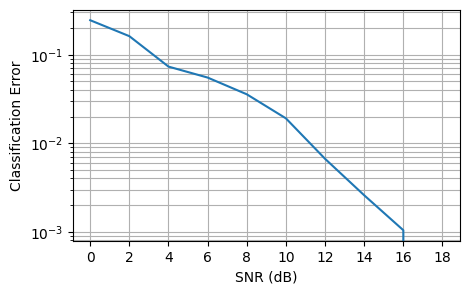

In [13]:
# Plot Results
plt.figure(figsize=(5,3))
plt.plot(SNRs_task_1, err_rates)
plt.yscale('log')
plt.axis('tight')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Error')
plt.xticks(SNRs_task_1)
plt.grid(which='both')
plt.savefig('Competition_Task1_CER_Plot.pdf', bbox_inches='tight')

In [19]:
### Your code goes here :)

# 1) Build the IQ tensor for the submission set
def make_iq_tensor(X_complex):
    arr = np.stack([X_complex.real, X_complex.imag], axis=1)  # (N,2,128)
    return arr[:, None, :, :]                                # (N,1,2,128)
    
#  Submit set tensors on CPU 
X_submit_np = make_iq_tensor(np.array(X_test_task_1))       # (N,1,2,128)
X_submit_t = torch.from_numpy(X_submit_np).float()  # (N,1,2,128), on CPU

# 2) DataLoader with CPU tensors + pin_memory
submit_loader = DataLoader(
    X_submit_t,              
    batch_size=32,
    shuffle=False,
    pin_memory=True          
)

# 3) Move the batch to the GPU in the loop again
model.eval()
all_preds = []
with torch.no_grad():
    for xb in submit_loader:           # xb here is CPU tensor
        xb = xb.to(device, non_blocking=True)  # to  GPU
        logits = model(xb)
        preds  = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)

predictions_task_1 = np.concatenate(all_preds, axis=0)

### Here, get the predictions from your model that will be submitted 
#predictions_task_1 = np.random.randint(0, len(mod_names_task_1), size=X_test_task_1.shape[0])

### Don't touch this part
check_predictions(X_test_task_1, predictions_task_1, range(len(mod_names_task_1)))

with open('Task_1_%s.pkl' % (team_name),'wb') as f:
    pickle.dump(predictions_task_1,f)

type ok.
dim ok.
length ok.
Predictions are valid values.
